# <center>Deep Learning Project</center>
<br>
<b>Name : </b>Daniel Sabba <br> 
<b>Project Name : </b>Named Entity Recognition using RNN

# Imports


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model, Input, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D,Flatten,GRU
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Data Processing

My dataset contains a total of 3482 sentences, which is constructed from 59883 words.<br>
the dataset has 18752 unique words and 101 unique chars, there are 17 different tags, and 1 more tag for padding - total 18.
<br>
data set providers https://www.cs.bgu.ac.il/~elhadad/nlpproj/naama/


In [ ]:
with open(r"trainSet",encoding = "utf8") as fp:
    dict_list = fp.readlines();

i = 0
start = 0
sentences = []
for elem in dict_list:
    if(elem == "\n" and "DOCSTART" not in elem ):
        sentences.append(" ".join(dict_list[start:i]))
        start = i
    i+=1
    
sentences.remove("--DOCSTART-- O\n")

for i in range(len(sentences)):
    sentences[i] = sentences[i].replace("\n","")
    while(sentences[i].startswith(" ")):
        sentences[i] = sentences[i][1:]
    while(sentences[i].endswith(" ")):
        sentences[i] = sentences[i][:-1]
    while(sentences[i].endswith(". O")):
        sentences[i] = sentences[i][:-3]
    while(sentences[i].endswith(" ")):
        sentences[i] = sentences[i][:-1]
        
all_tags = []
clean_sent = []
clean_tags = []
df = {}
n = 0
for sent in sentences:
    i = 0
    temp_tags = []
    temp_sent = []
    for word in sent.split(" "):
        if(i%2 == 0):
            temp_sent.append(word)
        else:
            temp_tags.append(word)
            all_tags.append(word)
            all_tags = list(set(all_tags))
        i+=1
    clean_sent.append(temp_sent)
    clean_tags.append(temp_tags)

all_tags.append("PADDING")    
tags_dict = {}
for i in range(0,len(all_tags)):
    tags_dict.update({all_tags[i]:i})

In [ ]:
n_tags = len(all_tags)
words = []
for sent in clean_sent:
    for word in sent:
        if(word not in words):
            words.append(word)
n_words = len(words)

chars = []
for sent in clean_sent:
    for word in sent:
        for char in word:
            if(char not in chars):
                chars.append(char)
chars = sorted(chars)
n_chars = len(chars)

    # Building dictionaries to help build the corpus
word2idx = {w: i + 1 for i, w in enumerate(words)}
word2idx["PADDING"] = 0

char2idx = {c: i + 1 for i, c in enumerate(chars)}
char2idx["PADDING"] = 0

tag2idx = {t: i+1 for i, t in enumerate(all_tags)}
tag2idx["PADDING"] = 0
    # Building the word corpus using the words dictionarie
X_word = [[word2idx[w] for w in s] for s in clean_sent]
X_word = np.array(X_word)

max_len = 75

# Padding the sentences vectors with zeros, so all of my sentences will have the same length
X_word_padded = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PADDING"], padding='post', truncating='post')

max_len_char = 10

    # Building my charecter vectors, each word will become a vector of size max_len_char.
    # Using the char2idx dictionarie
X_char = []
for sentence in clean_sent:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][j]))
            except:
                word_seq.append(char2idx.get("PADDING"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))
    
X_char = np.array(X_char)

    # Building the corresponding label data.
y = [[tag2idx[w] for w in s] for s in clean_tags]
y = np.array(y)

    # Padding the labels with zeros, so it will match the length of the new padded sentences
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PADDING"], padding='post', truncating='post')
y2 = y.reshape(y.shape[0],y.shape[1],1)

    # Splitting the data into train and test.
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word_padded, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

In [6]:
flat_list = []
for sublist in clean_sent:
    for item in sublist:
        flat_list.append(item)

flat_list2 = []
for sublist in clean_tags:
    for item in sublist:
        flat_list2.append(item)

temp = {"Words" : flat_list[:10],"Tags":flat_list2[:10]}
      
df = pd.DataFrame(temp)

total_tags = 0
count_padding = 0
count_other = 0
for sent in y_te:
    for tag in sent:
        total_tags+=1
        if(tag == 0):
            count_padding +=1
        if(tag == tag2idx["O"]):
            count_other+=1
           
        
def plot_hist(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
        
    
def get_tags(pred):
    pred_tags = []
    for sent in pred:
        ans = []
        for word in sent:
            ans.append(word.argmax())
        pred_tags.append(ans)
    return pred_tags

def get_hits(y_te,pred_tags):
    hits = 0
    count_pad = 0
    count_o = 0
    for real_tag,pred_tag in zip(y_te,pred_tags):
        for y,yhat in zip(real_tag,pred_tag):
            try:
                if(y == yhat and yhat != 0 and y != tag2idx["O"]):
                    hits +=1
                if(yhat == tag2idx["PADDING"]):
                    count_pad +=1
                if(yhat == tag2idx["O"]):
                    count_o +=1
            except:
                try:
                    if(y == yhat[0] and yhat[0] != 0 and y != tag2idx["O"]):
                        hits +=1
                    if(yhat[0] == tag2idx["PADDING"]):
                        count_pad +=1
                    if(yhat[0] == tag2idx["O"]):
                        count_o +=1
                except:
                    if(y == yhat and yhat != 0 and y != tag2idx["O"]):
                        hits +=1
                    if(yhat == tag2idx["PAD"]):
                        count_pad +=1
                    if(yhat == tag2idx["O"]):
                        count_o +=1
                    
    return hits,count_pad,count_o

def print_scores(hits,count_pad,count_o):
    print("Total tags :", total_tags)
    print("# of 'P' :", count_padding)
    print("# of 'O' :", count_other)
    print("Total tags left without O,P :", total_tags - count_other - count_padding)
    print("# of hits without 'PAD' and 'O' :", hits)
    print("# of predicted - 'O' :", count_o)
    print("# of predicted - 'PAD' :", count_pad)
    print("Accuracy rate : ", hits/(total_tags - count_other - count_padding))
    
def from_catagorical(y_te):
    new_y_te = []
    for sent in y_te:
        newsent = []
        for word in sent:
            newsent.append(word.argmax())
        new_y_te.append(newsent)
    return new_y_te

# My dataset

In [ ]:
df

,Words,Tags
0,נראה,O
1,שאביטל,I_PERS
2,אברג'יל,I_PERS
3,(,O
4,לשעבר,O
5,אוז,I_PERS
6,),O
7,",",O
8,אוהבת,O
9,לא,O


In [ ]:
tags_dict

{'B_DATE': 6,
 'B_LOC': 12,
 'B_MISC__AFF': 1,
 'B_MISC__ENT': 0,
 'B_ORG': 4,
 'B_PERS': 11,
 'B_TIME': 9,
 'I_DATE': 2,
 'I_LOC': 15,
 'I_MISC_EVENT': 8,
 'I_MISC__AFF': 16,
 'I_MISC__ENT': 13,
 'I_MONEY': 3,
 'I_ORG': 5,
 'I_PERCENT': 7,
 'I_PERS': 10,
 'I_TIME': 14,
 'O': 17,
 'PADDING': 18}

<BarContainer object of 18 artists>

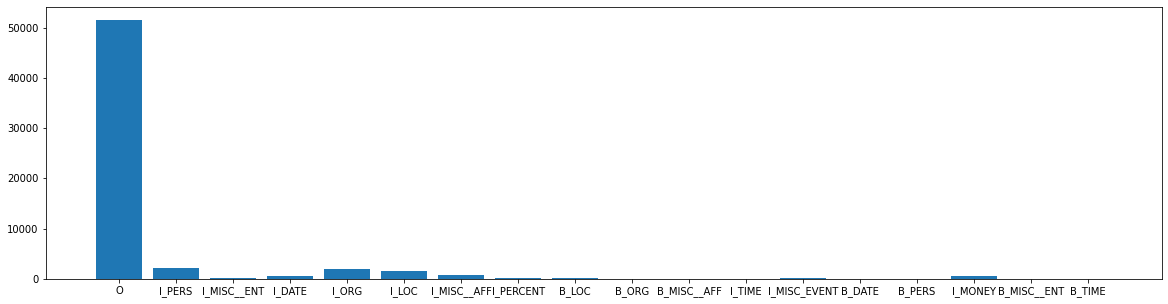

In [ ]:
plt.figure(figsize = (20,5))
w = Counter(flat_list2)
plt.bar(w.keys(), w.values())

Here we can see the distribution of the tags

# Model Selection

## Model 1: Simple NN

### Layers explanation :

#### Input layer 
The input layer is used to instantiate a Keras tensor - (n-dimentions metrice)
A Keras tensor is a TensorFlow symbolic tensor object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model.<br>
input used in this model is a corpus constructed from the word vectors.<br>
https://keras.io/api/layers/core_layers/input/

#### Dense layer
Dense layer is the regular deeply connected neural network layer. It is most common and frequently used layer. Dense layer does the below operation on the input and return the output.<br>
when using a dense layer with a "softmax" or "sigmoid" activation, it becomes a "Decoder".<br>
the decoder helpes us translate a vector into the output that matches it.<br>
https://www.quora.com/In-Keras-what-is-a-dense-and-a-dropout-layer

#### Dropout layer and Regularizers

The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.<br>

Regularizers allow you to apply penalties on layer parameters or layer activity during optimization. These penalties are summed into the loss function that the network optimizes.<br>
https://keras.io/api/layers/regularization_layers/dropout/<br>
https://keras.io/api/layers/regularizers/


In [ ]:
word_input = Input(shape = (X_word_tr.shape[1],))

layer1 = Dense(8,activation = "relu",kernel_regularizer="l2")(word_input)
layer2 = Dense(16,activation = "relu",kernel_regularizer="l2")(layer1)
dropout3 = Dropout(0.4)(layer2)
layer4 = Dense(32,activation = "relu",kernel_regularizer="l2")(dropout3)
layer5 = Dense(16,activation = "relu",kernel_regularizer="l2")(layer4)
dropout6 = Dropout(0.4)(layer5)
out = Dense(max_len,activation = "softmax")(dropout6)

model = Model(word_input,out)
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics = ["acc"])

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 608       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)               

In [ ]:
history = model.fit(X_word_tr,y_tr,epochs = 300,validation_data = (X_word_te,y_te),batch_size=64)

Epoch 1/300
49/49 [==============================] - 0s 4ms/step - loss: 16058257802002432.0000 - acc: 0.2123 - val_loss: 17371935826509824.0000 - val_acc: 0.0000e+00
Epoch 2/300
49/49 [==============================] - 0s 3ms/step - loss: 16121695542706176.0000 - acc: 0.2154 - val_loss: 17836160587923456.0000 - val_acc: 0.0000e+00
Epoch 3/300
49/49 [==============================] - 0s 3ms/step - loss: 17185193869705216.0000 - acc: 0.1982 - val_loss: 18289594244005888.0000 - val_acc: 0.0000e+00
Epoch 4/300
49/49 [==============================] - 0s 3ms/step - loss: 18156469585182720.0000 - acc: 0.2059 - val_loss: 18762710661464064.0000 - val_acc: 0.0000e+00
Epoch 5/300
49/49 [==============================] - 0s 3ms/step - loss: 17340820935933952.0000 - acc: 0.1957 - val_loss: 19248074178166784.0000 - val_acc: 0.0000e+00
Epoch 6/300
49/49 [==============================] - 0s 4ms/step - loss: 18685218714025984.0000 - acc: 0.1976 - val_loss: 19729782677700608.0000 - val_acc: 0.0000e+0

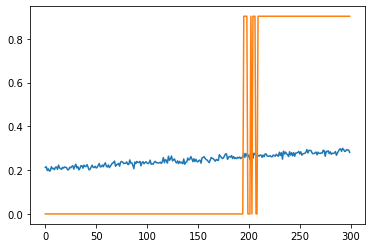

In [ ]:
plot_hist(history)

In [ ]:
pred = model.predict(X_word_te)

In [ ]:
pred_tags = get_tags(pred)

In [ ]:
hits,count_pad,count_o = get_hits(y_te,pred_tags)

In [ ]:
print_scores(hits,count_pad,count_o)

Total tags : 26175
# of 'P' : 19946
# of 'O' : 5403
Total tags left without O,P : 826
# of hits without 'PAD' and 'O' : 0
# of predicted - 'O' : 0
# of predicted - 'PAD' : 26175
Accuracy rate :  0.0


most of the tags are PADDINGS, so in order to get a small loss, the NN learned to give all the words the tag "PAD"(0).
we can go deeper with the net, adding some dropouts and use different initializers, but the best practice for sequenced data is undoubtedly RNN

## Model 2: Simple LSTM

In this model, I have tryed a simple RNN, which is built from a input layer, embedding layer, an LSTM layer and a dense layer.


### Layers explanation :


#### Embedding layer 
the Embedding layer turns positive integers (indexes) into dense vectors of fixed size.

#### LSTM layer 
Long Short-Term Memory layer - Hochreiter 1997.
A special kind of RNN, capable of learning long-term dependencies.
LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

There are several architectures of LSTM units. A common architecture is composed of a cell (the memory part of the LSTM unit) and three "regulators", usually called gates, of the flow of information inside the LSTM unit: an input gate, an output gate and a forget gate. Some variations of the LSTM unit do not have one or more of these gates or maybe have other gates. For example, gated recurrent units (GRUs) do not have an output gate.

The compact forms of the equations for the forward pass of an LSTM unit with a forget gate are:

<math>
\begin{align}
f_t &= \sigma_g(W_{f} x_t + U_{f} h_{t-1} + b_f) \\
i_t &= \sigma_g(W_{i} x_t + U_{i} h_{t-1} + b_i) \\
o_t &= \sigma_g(W_{o} x_t + U_{o} h_{t-1} + b_o) \\
\tilde{c}_t &= \sigma_c(W_{c} x_t + U_{c} h_{t-1} + b_c) \\
c_t &= f_t \circ c_{t-1} + i_t \circ \tilde{c}_t \\
h_t &= o_t \circ \sigma_h(c_t)
\end{align}
</math>
https://en.wikipedia.org/wiki/Long_short-term_memory

In [ ]:
word_input = Input(shape = (X_word_tr.shape[1],))
emb_word = Embedding(input_dim = n_words + 1,output_dim=16,mask_zero = True,input_length = max_len)(word_input)

lstm1 = LSTM(units=8, return_sequences=True)(emb_word)

out = Dense(n_tags,activation = 'softmax')(lstm1)

model = Model(word_input,out)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ["acc"])

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 75, 16)            300048    
_________________________________________________________________
lstm (LSTM)                  (None, 75, 8)             800       
_________________________________________________________________
dense_5 (Dense)              (None, 75, 19)            171       
Total params: 301,019
Trainable params: 301,019
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history2 = model.fit(X_word_tr,y_tr,validation_data = (X_word_te,y_te),epochs = 250,batch_size=256)

Epoch 1/250
13/13 [==============================] - 1s 107ms/step - loss: 0.6678 - acc: 0.6219 - val_loss: 0.6899 - val_acc: 0.8671
Epoch 2/250
13/13 [==============================] - 0s 17ms/step - loss: 0.6554 - acc: 0.8589 - val_loss: 0.6741 - val_acc: 0.8671
Epoch 3/250
13/13 [==============================] - 0s 16ms/step - loss: 0.6364 - acc: 0.8589 - val_loss: 0.6476 - val_acc: 0.8671
Epoch 4/250
13/13 [==============================] - 0s 18ms/step - loss: 0.6017 - acc: 0.8589 - val_loss: 0.5951 - val_acc: 0.8671
Epoch 5/250
13/13 [==============================] - 0s 17ms/step - loss: 0.5359 - acc: 0.8589 - val_loss: 0.5097 - val_acc: 0.8671
Epoch 6/250
13/13 [==============================] - 0s 17ms/step - loss: 0.4535 - acc: 0.8589 - val_loss: 0.4271 - val_acc: 0.8671
Epoch 7/250
13/13 [==============================] - 0s 17ms/step - loss: 0.3819 - acc: 0.8589 - val_loss: 0.3616 - val_acc: 0.8671
Epoch 8/250
13/13 [==============================] - 0s 20ms/step - loss: 0

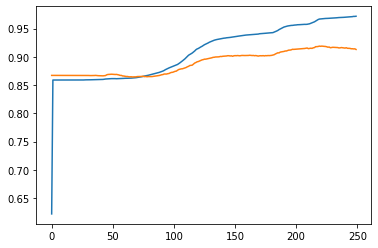

In [ ]:
plot_hist(history2)

In [ ]:
pred2 = model.predict(X_word_te)

In [ ]:
pred_tags = get_tags(pred2)

In [ ]:
hits ,count_pad ,count_o = get_hits(y_te,pred_tags)

In [ ]:
print_scores(hits,count_pad,count_o)

Total tags : 26175
# of 'P' : 19946
# of 'O' : 5403
Total tags left without O,P : 826
# of hits without 'PAD' and 'O' : 478
# of predicted - 'O' : 5419
# of predicted - 'PAD' : 0
Accuracy rate :  0.5786924939467313


## Model 3: Complex LSTM network 

In this model, i've joined the char vectors for each of the sentences, concatenating them to the sentece vector that is constructed with word vectors, making a one big vector for each sentence to feed the netword.

###Layers Explanation :

#### TimeDistributed layer 
This wrapper allows us to apply a layer to every temporal slice of an input.
use TimeDistributed to apply a type of a layer e.g. Conv2D layer to each of the 10 timesteps, independently.

https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

https://keras.io/api/layers/recurrent_layers/time_distributed/

#### Bidirectional LSTM 
which is a combination of two LSTMs — one runs forward from “right to left” and one runs backward from “left to right”.

https://towardsdatascience.com/named-entity-recognition-ner-meeting-industrys-requirement-by-applying-state-of-the-art-deep-698d2b3b4ede

#### SpatialDropout1D
 This version performs the same function as Dropout, however it drops entire 1D feature maps instead of individual elements

https://www.rdocumentation.org/packages/keras/versions/2.0.6/topics/layer_spatial_dropout_1d

In [ ]:
word_input = Input(shape = (X_word_tr.shape[1],))
emb_word = Embedding(input_dim = n_words + 1,output_dim=16,mask_zero = True,input_length = max_len)(word_input)

char_input = Input(shape = (X_char_tr.shape[1],X_char_tr.shape[2],))
emb_char = Embedding(input_dim = n_chars + 1,output_dim = 16,mask_zero = True,input_length = (X_char_tr.shape[1],X_char_tr.shape[2],))(char_input)

#flatten = Flatten(emb_word)

lstm_word = LSTM(units=8, return_sequences=True,activation = 'tanh',recurrent_activation= 'sigmoid',
                 recurrent_dropout= 0,unroll = False,use_bias = True)(emb_word)


char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,activation = 'tanh',recurrent_activation= 'sigmoid',
                 recurrent_dropout= 0.5,unroll = False,use_bias = True))(emb_char)

x = concatenate([lstm_word, char_enc])
x = SpatialDropout1D(0.3)(x)

main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,activation = 'tanh',recurrent_activation= 'sigmoid',
                 recurrent_dropout= 0,unroll = False,use_bias = True))(x)

out = Dense(n_tags,input_dim = (max_len,),activation = "softmax")(main_lstm)

model = Model([word_input, char_input], out)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics="acc")

In [ ]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 75, 10)]     0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 75, 16)       300048      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 75, 10, 16)   1632        input_5[0][0]                    
_______________________________________________________________________________________

In [ ]:
history3 = model.fit([X_word_tr,X_char_tr],y_tr,validation_data = ([X_word_te,X_char_te],y_te),batch_size=256, epochs=250)

Epoch 1/250
13/13 [==============================] - 5s 358ms/step - loss: 0.6484 - acc: 0.7916 - val_loss: 0.6096 - val_acc: 0.8671
Epoch 2/250
13/13 [==============================] - 1s 88ms/step - loss: 0.4181 - acc: 0.8589 - val_loss: 0.2264 - val_acc: 0.8671
Epoch 3/250
13/13 [==============================] - 1s 84ms/step - loss: 0.2280 - acc: 0.8589 - val_loss: 0.2102 - val_acc: 0.8671
Epoch 4/250
13/13 [==============================] - 1s 86ms/step - loss: 0.1960 - acc: 0.8589 - val_loss: 0.1819 - val_acc: 0.8671
Epoch 5/250
13/13 [==============================] - 1s 84ms/step - loss: 0.1802 - acc: 0.8589 - val_loss: 0.1752 - val_acc: 0.8671
Epoch 6/250
13/13 [==============================] - 1s 84ms/step - loss: 0.1727 - acc: 0.8589 - val_loss: 0.1686 - val_acc: 0.8671
Epoch 7/250
13/13 [==============================] - 1s 88ms/step - loss: 0.1678 - acc: 0.8589 - val_loss: 0.1651 - val_acc: 0.8671
Epoch 8/250
13/13 [==============================] - 1s 90ms/step - loss: 0

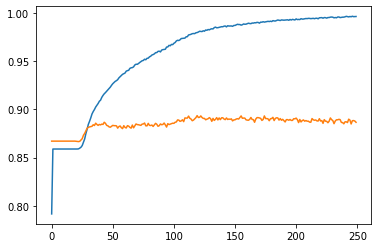

In [ ]:
plot_hist(history3)

In [ ]:
pred3 = model.predict([X_word_te,X_char_te])

In [ ]:
pred_tags = get_tags(pred3)

In [ ]:
hits ,count_pad ,count_o = get_hits(y_te,pred_tags)

In [ ]:
print_scores(hits,count_pad,count_o)

Total tags : 26175
# of 'P' : 19946
# of 'O' : 5403
Total tags left without O,P : 826
# of hits without 'PAD' and 'O' : 397
# of predicted - 'O' : 5366
# of predicted - 'PAD' : 0
Accuracy rate :  0.48062953995157387


## Model 4: GRU network

In this model, i've changed all the LSTM to GRU.

### Layers Explanation

#### Gated Recurrent Unit - GRU

The GRU is the newer generation of Recurrent Neural networks and is pretty similar to an LSTM.<br> GRU’s got rid of the cell state and used the hidden state to transfer information. It also only has two gates, a reset gate and update gate.<br>
The update gate acts similar to the forget and input gate of an LSTM.<br> It decides what information to throw away and what new information to add
The reset gate is another gate is used to decide how much past information to forget.<br>
https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [ ]:
word_input = Input(shape = (X_word_tr.shape[1],))
emb_word = Embedding(input_dim = n_words + 1,output_dim=16,mask_zero = True,input_length = max_len)(word_input)

char_input = Input(shape = (X_char_tr.shape[1],X_char_tr.shape[2],))
emb_char = Embedding(input_dim = n_chars + 1,output_dim = 16,mask_zero = True,input_length = (X_char_tr.shape[1],X_char_tr.shape[2],))(char_input)

#flatten = Flatten(emb_word)

lstm_word = GRU(units=8, return_sequences=True)(emb_word)

char_enc = TimeDistributed(GRU(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)


lstm_char = GRU(units=8, return_sequences=True)(char_enc)

lstm_word = SpatialDropout1D(0.3)(lstm_word)
lstm_char = SpatialDropout1D(0.3)(lstm_char)

x = concatenate([lstm_word, lstm_char])
x = SpatialDropout1D(0.3)(x)

main_lstm = Bidirectional(GRU(units=50, return_sequences=True))(x)

out = Dense(n_tags+1,input_dim = (max_len,),activation = "softmax")(main_lstm)

model = Model([word_input, char_input], out)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=['acc'])

In [ ]:
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 75, 10)]     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 75, 10, 16)   1632        input_7[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 75, 16)       300048      input_6[0][0]                    
_______________________________________________________________________________________

In [ ]:
history4 = model.fit([X_word_tr,X_char_tr],y_tr,validation_data = ([X_word_te,X_char_te],y_te),batch_size=256, epochs=250)

Epoch 1/250
13/13 [==============================] - 6s 446ms/step - loss: 0.6501 - acc: 0.7845 - val_loss: 0.6033 - val_acc: 0.8671
Epoch 2/250
13/13 [==============================] - 1s 83ms/step - loss: 0.4480 - acc: 0.8589 - val_loss: 0.2166 - val_acc: 0.8671
Epoch 3/250
13/13 [==============================] - 1s 79ms/step - loss: 0.2261 - acc: 0.8589 - val_loss: 0.2086 - val_acc: 0.8671
Epoch 4/250
13/13 [==============================] - 1s 81ms/step - loss: 0.1952 - acc: 0.8589 - val_loss: 0.1780 - val_acc: 0.8671
Epoch 5/250
13/13 [==============================] - 1s 80ms/step - loss: 0.1822 - acc: 0.8589 - val_loss: 0.1698 - val_acc: 0.8671
Epoch 6/250
13/13 [==============================] - 1s 88ms/step - loss: 0.1737 - acc: 0.8589 - val_loss: 0.1659 - val_acc: 0.8671
Epoch 7/250
13/13 [==============================] - 1s 80ms/step - loss: 0.1682 - acc: 0.8589 - val_loss: 0.1629 - val_acc: 0.8671
Epoch 8/250
13/13 [==============================] - 1s 82ms/step - loss: 0

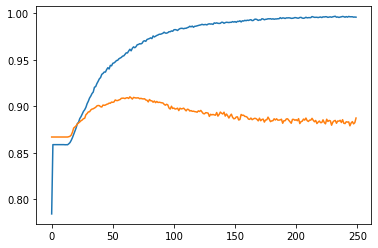

In [ ]:
plot_hist(history4)

In [ ]:
pred4 = model.predict([X_word_te,np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))])

In [ ]:
pred_tags = get_tags(pred4)

In [ ]:
hits , count_pad , count_o = get_hits(y_te,pred_tags)

In [ ]:
print_scores(hits , count_pad , count_o)

Total tags : 26175
# of 'P' : 19946
# of 'O' : 5403
Total tags left without O,P : 826
# of hits without 'PAD' and 'O' : 343
# of predicted - 'O' : 5467
# of predicted - 'PAD' : 0
Accuracy rate :  0.4152542372881356


## Model 5: LSTM - CRF word based

#### CRF - Condinital Random Field
Conditional random fields (CRFs) are a class of statistical modeling method often applied in pattern recognition and machine learning and used for structured prediction.<br>
 Whereas a classifier predicts a label for a single sample without considering "neighboring" samples, a CRF can take context into account.<br> To do so, the prediction is modeled as a graphical model, which implements dependencies between the predictions.<br>
https://en.wikipedia.org/wiki/Conditional_random_field

In [ ]:
#!pip install keras --upgrade
import tensorflow.keras.backend as K
from keras_contrib.layers import CRF

In [ ]:
y = [to_categorical(i, num_classes=n_tags) for i in y]
y = np.array(y)

In [ ]:
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word_padded, y, test_size=0.1)

In [ ]:
word_input = Input(shape = (X_word_tr.shape[1],))
emb_word = Embedding(input_dim = n_words + 1,output_dim=16,mask_zero = True,input_length = max_len)(word_input)

model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(emb_word)  # variational biLSTM

model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(word_input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



C:\Anaconda\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Anaconda\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 16)            300048    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           26800     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 19)            1368      
Total params: 333,266
Trainable params: 333,266
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history5 = model.fit(X_word_tr, np.array(y_tr),validation_data = (X_word_te, np.array(y_te)), batch_size=64, epochs=150)




Train on 3133 samples, validate on 349 samples
Epoch 1/150





3133/3133 [==============================] - 7s 2ms/step - loss: 28.0295 - crf_viterbi_accuracy: 0.6948 - val_loss: 26.1638 - val_crf_viterbi_accuracy: 0.8628
Epoch 2/150
3133/3133 [==============================] - 5s 2ms/step - loss: 27.1819 - crf_viterbi_accuracy: 0.8582 - val_loss: 25.8954 - val_crf_viterbi_accuracy: 0.8662
Epoch 3/150
3133/3133 [==============================] - 7s 2ms/step - loss: 26.9731 - crf_viterbi_accuracy: 0.8593 - val_loss: 25.7632 - val_crf_viterbi_accuracy: 0.8662
Epoch 4/150
3133/3133 [==============================] - 7s 2ms/step - loss: 26.8564 - crf_viterbi_accuracy: 0.8590 - val_loss: 25.6800 - val_crf_viterbi_accuracy: 0.8664
Epoch 5/150
3133/3133 [==============================] - 7s 2ms/step - loss: 26.7627 - crf_viterbi_accuracy: 0.8644 - val_loss: 25.6291 - val_crf_viterbi_accuracy: 0.8759
Epoch 6/150
3133/3133 [==============================] - 7s 2ms/step - loss: 26.6952 - crf

Epoch 40/150
3133/3133 [==============================] - 6s 2ms/step - loss: 26.3450 - crf_viterbi_accuracy: 0.9940 - val_loss: 25.9849 - val_crf_viterbi_accuracy: 0.8496
Epoch 41/150
3133/3133 [==============================] - 6s 2ms/step - loss: 26.3431 - crf_viterbi_accuracy: 0.9947 - val_loss: 26.0379 - val_crf_viterbi_accuracy: 0.8357
Epoch 42/150
3133/3133 [==============================] - 6s 2ms/step - loss: 26.3424 - crf_viterbi_accuracy: 0.9951 - val_loss: 26.0211 - val_crf_viterbi_accuracy: 0.8424
Epoch 43/150
3133/3133 [==============================] - 6s 2ms/step - loss: 26.3399 - crf_viterbi_accuracy: 0.9965 - val_loss: 26.1215 - val_crf_viterbi_accuracy: 0.8216
Epoch 44/150
3133/3133 [==============================] - 6s 2ms/step - loss: 26.3384 - crf_viterbi_accuracy: 0.9964 - val_loss: 26.0479 - val_crf_viterbi_accuracy: 0.8433
Epoch 45/150
3133/3133 [==============================] - 6s 2ms/step - loss: 26.3372 - crf_viterbi_accuracy: 0.9974 - val_loss: 26.1225 - v

3133/3133 [==============================] - 6s 2ms/step - loss: 26.3279 - crf_viterbi_accuracy: 1.0000 - val_loss: 26.9412 - val_crf_viterbi_accuracy: 0.8413
Epoch 135/150
3133/3133 [==============================] - 6s 2ms/step - loss: 26.3279 - crf_viterbi_accuracy: 1.0000 - val_loss: 26.8484 - val_crf_viterbi_accuracy: 0.8512
Epoch 136/150
3133/3133 [==============================] - 6s 2ms/step - loss: 26.3279 - crf_viterbi_accuracy: 1.0000 - val_loss: 26.9169 - val_crf_viterbi_accuracy: 0.8459
Epoch 137/150
3133/3133 [==============================] - 6s 2ms/step - loss: 26.3279 - crf_viterbi_accuracy: 1.0000 - val_loss: 26.8977 - val_crf_viterbi_accuracy: 0.8399
Epoch 138/150
3133/3133 [==============================] - 6s 2ms/step - loss: 26.3279 - crf_viterbi_accuracy: 1.0000 - val_loss: 26.8283 - val_crf_viterbi_accuracy: 0.8499
Epoch 139/150
3133/3133 [==============================] - 6s 2ms/step - loss: 26.3279 - crf_viterbi_accuracy: 1.0000 - val_loss: 26.8097 - val_crf_v

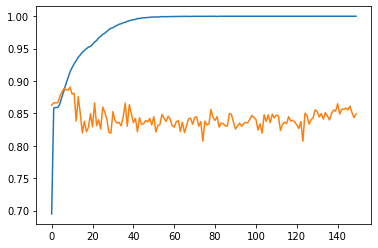

In [ ]:
plt.plot(history5.history['crf_viterbi_accuracy'])
plt.plot(history5.history['val_crf_viterbi_accuracy'])

In [ ]:
pred5 = model.predict(X_word_te)

In [ ]:
pred_tags = get_tags(pred5)

In [ ]:
new_y_te = from_catagorical(y_te)

In [ ]:
hits , count_pad , count_o = get_hits(new_y_te,pred_tags)

In [ ]:
print_scores(hits , count_pad , count_o)

Total tags : 26175
# of 'P' : 19946
# of 'O' : 5403
Total tags left without O,P : 826
# of hits without 'PAD' and 'O' : 483
# of predicted - 'O' : 4725
# of predicted - 'PAD' : 20229
Accuracy rate :  0.5847457627118644


## Model 6 : LSTM-CRF word and char

In [ ]:
char_input = Input(shape = (X_char.shape[1],X_char.shape[2],))

emb_char = Embedding(input_dim = n_chars + 1,output_dim = 16,mask_zero = True,
                     input_length = (X_char_tr.shape[1],X_char_tr.shape[2],))(char_input)

char_enc = TimeDistributed(GRU(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

#lstm_char = LSTM(units=8, return_sequences=True)(char_enc)

word_input = Input(shape = (X_word_tr.shape[1],))
emb_word = Embedding(input_dim = n_words + 1,output_dim=16,mask_zero = True,input_length = max_len)(word_input)

lstm_word = LSTM(units=8, return_sequences=True)(emb_word)

x = concatenate([lstm_word, char_enc])
x = SpatialDropout1D(0.3)(x)

model = Bidirectional(LSTM(units=50, return_sequences=True,recurrent_dropout=0.1))(x)  # variational biLSTM

model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model([char_input,word_input], out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

C:\Anaconda\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Anaconda\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


In [ ]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 75, 16)       300048      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 75, 10, 16)   1632        input_2[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LS

In [ ]:
history6 = model.fit([X_char_tr,X_word_tr], y_tr,validation_data = ([X_char_te,X_word_te], y_te), batch_size=256, epochs=200)

Train on 3133 samples, validate on 349 samples
Epoch 1/200
3133/3133 [==============================] - 11s 3ms/step - loss: 43.0142 - crf_viterbi_accuracy: 0.9910 - val_loss: 38.9728 - val_crf_viterbi_accuracy: 0.8415
Epoch 2/200
3133/3133 [==============================] - 12s 4ms/step - loss: 43.0149 - crf_viterbi_accuracy: 0.9900 - val_loss: 39.0133 - val_crf_viterbi_accuracy: 0.8218
Epoch 3/200
3133/3133 [==============================] - 14s 5ms/step - loss: 43.0147 - crf_viterbi_accuracy: 0.9903 - val_loss: 39.0215 - val_crf_viterbi_accuracy: 0.8315
Epoch 4/200
3133/3133 [==============================] - 15s 5ms/step - loss: 43.0113 - crf_viterbi_accuracy: 0.9927 - val_loss: 38.9873 - val_crf_viterbi_accuracy: 0.8500
Epoch 5/200
3133/3133 [==============================] - 15s 5ms/step - loss: 43.0145 - crf_viterbi_accuracy: 0.9907 - val_loss: 39.0283 - val_crf_viterbi_accuracy: 0.8349
Epoch 6/200
3133/3133 [==============================] - 14s 4ms/step - loss: 43.0122 - crf_v

3133/3133 [==============================] - 14s 4ms/step - loss: 43.0037 - crf_viterbi_accuracy: 0.9961 - val_loss: 39.3943 - val_crf_viterbi_accuracy: 0.8371
Epoch 96/200
3133/3133 [==============================] - 14s 5ms/step - loss: 43.0023 - crf_viterbi_accuracy: 0.9966 - val_loss: 39.4056 - val_crf_viterbi_accuracy: 0.8349
Epoch 97/200
3133/3133 [==============================] - 15s 5ms/step - loss: 43.0036 - crf_viterbi_accuracy: 0.9967 - val_loss: 39.4282 - val_crf_viterbi_accuracy: 0.8359
Epoch 98/200
3133/3133 [==============================] - 14s 5ms/step - loss: 43.0047 - crf_viterbi_accuracy: 0.9955 - val_loss: 39.4101 - val_crf_viterbi_accuracy: 0.8380
Epoch 99/200
3133/3133 [==============================] - 14s 4ms/step - loss: 43.0036 - crf_viterbi_accuracy: 0.9971 - val_loss: 39.4376 - val_crf_viterbi_accuracy: 0.8420
Epoch 100/200
3133/3133 [==============================] - 14s 5ms/step - loss: 43.0056 - crf_viterbi_accuracy: 0.9968 - val_loss: 39.4536 - val_crf

3133/3133 [==============================] - 15s 5ms/step - loss: 42.9999 - crf_viterbi_accuracy: 0.9987 - val_loss: 39.7570 - val_crf_viterbi_accuracy: 0.8391
Epoch 190/200
3133/3133 [==============================] - 15s 5ms/step - loss: 42.9987 - crf_viterbi_accuracy: 0.9985 - val_loss: 39.7539 - val_crf_viterbi_accuracy: 0.8311
Epoch 191/200
3133/3133 [==============================] - 15s 5ms/step - loss: 42.9996 - crf_viterbi_accuracy: 0.9979 - val_loss: 39.7541 - val_crf_viterbi_accuracy: 0.8420
Epoch 192/200
3133/3133 [==============================] - 14s 5ms/step - loss: 43.0022 - crf_viterbi_accuracy: 0.9976 - val_loss: 39.7640 - val_crf_viterbi_accuracy: 0.8398
Epoch 193/200
3133/3133 [==============================] - 15s 5ms/step - loss: 42.9991 - crf_viterbi_accuracy: 0.9983 - val_loss: 39.7954 - val_crf_viterbi_accuracy: 0.8373
Epoch 194/200
3133/3133 [==============================] - 15s 5ms/step - loss: 43.0002 - crf_viterbi_accuracy: 0.9973 - val_loss: 39.8231 - val

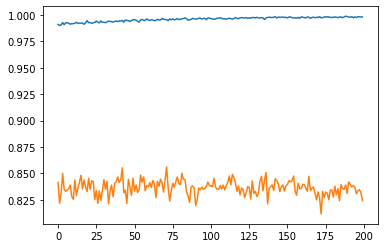

In [ ]:
plt.plot(history6.history['crf_viterbi_accuracy'])
plt.plot(history6.history['val_crf_viterbi_accuracy'])

In [ ]:
pred6 = model.predict([X_char_te,X_word_te])

In [ ]:
pred_tags = get_tags(pred6)

In [ ]:
hits,count_pad,count_o = get_hits(new_y_te,pred_tags)

In [ ]:
print_scores(hits,count_pad,count_o)

Total tags : 26175
# of 'P' : 19946
# of 'O' : 5403
Total tags left without O,P : 826
# of hits without 'PAD' and 'O' : 13
# of predicted - 'O' : 3491
# of predicted - 'PAD' : 21910
Accuracy rate :  0.015738498789346248


# cuDNN 
The NVIDIA CUDA Deep Neural Network library (cuDNN) is a GPU-accelerated library of primitives for deep neural networks.<br> 
cuDNN provides highly tuned implementations for standard routines such as forward and backward convolution, pooling, normalization, and activation layers, cuDNN is used to accelerate the learning time.<br><br>
The requirements to use the cuDNN implementation are:<br>
1.activation == tanh<br>
2.recurrent_activation == sigmoid<br>
3.recurrent_dropout == 0<br>
4.unroll is False<br>
5.use_bias is True<br>
6.Inputs, if use masking, are strictly right-padded.<br>
7.Eager execution is enabled in the outermost context.<br>

https://developer.nvidia.com/cudnn

# Comparing to a bigger dataset

Getting a large,good tagged dataset for a specific langauge is a hard task.<br>
In order to valuate my hit rates, we will try a bigger dataset, on several models, and compare the accuracy rate.<br>
I am going to use a English dataset.<br>
In this dataset, there are - 47,958 sentences, with 35,178 unique words, and 98 unique chars.<br>
https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

## Data Processing

In [200]:
df = pd.read_csv("ner_dataset.csv",encoding= 'unicode_escape')
df["Sentence #"] = df["Sentence #"].fillna("")
df = df.fillna(0)
starting_idxs = list(df[df["Sentence #"] != ""].index)
sentences = []
poses = []
tags = []
for idx in range(len(starting_idxs)-1):
    sent = df['Word'][starting_idxs[idx]:starting_idxs[idx+1]]
    sentences.append(sent)
    pos = df['POS'][starting_idxs[idx]:starting_idxs[idx+1]]
    poses.append(pos)
    tag = list(df['Tag'][starting_idxs[idx]:starting_idxs[idx+1]])
    tags.append(tag)
words = []
for sent in sentences:
    for word in sent:
        if(word not in words):
            words.append(word)
n_words = len(words)
word2idx = {w: i + 1 for i, w in enumerate(words)}
word2idx["PAD"] = 0
distinct_tags = list(set(df["Tag"].values))
tag2idx = {t: i + 1 for i, t in enumerate(distinct_tags)}
tag2idx["PAD"] = 0
n_tags = len(distinct_tags) + 1
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
char2idx = {c: i + 1 for i, c in enumerate(chars)}
char2idx["PAD"] = 0
X_word = [[word2idx[w] for w in s] for s in sentences]
X_word = pad_sequences(maxlen=75, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

y = [[tag2idx[w] for w in s] for s in tags]
y = np.array(y)
    # Padding the labels with zeros, so it will match the length of the new padded sentences
max_len = 75
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')
y = y.reshape(y.shape[0],y.shape[1],1)
#
max_len = 75
max_len_char = 10
X_char = []

for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))
X_char = np.array(X_char)


X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, asf, asd = train_test_split(X_char, y, test_size=0.1)

temp = y.reshape(y.shape[0],y.shape[1]) 
y2 = [to_categorical(i, num_classes=n_tags+1) for i in temp] # this is for the crf
y2 = np.array(y2)
X_word_tr2, X_word_te2, y_tr2, y_te2 = train_test_split(X_word, y2, test_size=0.1, random_state=2018)
new_y_te = from_catagorical(y_te2)
new_y_te= np.array(new_y_te)

In [201]:
total_tags = 0
count_padding = 0
count_other = 0
for sent in y_te:
    for tag in sent:
        total_tags+=1
        if(tag == 0):
            count_padding +=1
        if(tag == tag2idx["O"]):
            count_other+=1

In [ ]:
df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,,of,IN,O
2,,demonstrators,NNS,O
3,,have,VBP,O
4,,marched,VBN,O
...,...,...,...,...
1048570,,they,PRP,O
1048571,,responded,VBD,O
1048572,,to,TO,O
1048573,,the,DT,O


<BarContainer object of 17 artists>

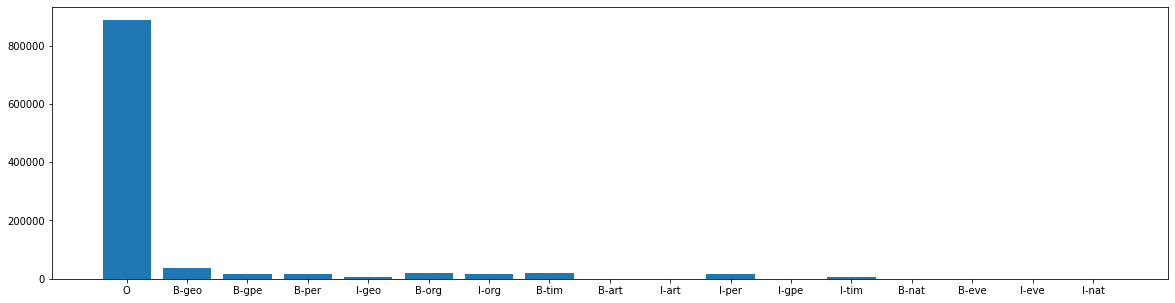

In [ ]:
flat_list2 = []
for sublist in tags:
    for item in sublist:
        flat_list2.append(item)

plt.figure(figsize = (20,5))
w = Counter(flat_list2)
plt.bar(w.keys(), w.values())

## Model selection

### Model 2: Simple LSTM

In [13]:
word_input = Input(shape = (X_word_tr.shape[1],))
emb_word = Embedding(input_dim = n_words + 1,output_dim=16,mask_zero = True,input_length = max_len)(word_input)

lstm1 = LSTM(units=8, return_sequences=True)(emb_word)

out = Dense(n_tags+1,activation = "softmax")(lstm1)

model = Model(word_input,out)

model.compile(optimizer="adam", loss="categorical_crossentropy",metrics = ["acc"])

In [14]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 16)            562864    
_________________________________________________________________
lstm_1 (LSTM)                (None, 75, 8)             800       
_________________________________________________________________
dense_1 (Dense)              (None, 75, 19)            171       
Total params: 563,835
Trainable params: 563,835
Non-trainable params: 0
_________________________________________________________________


In [15]:
history8 = model.fit(X_word_tr,y_tr2,validation_data = (X_word_te,y_te2),epochs = 120,batch_size=1024)

Epoch 1/120
43/43 [==============================] - 4s 101ms/step - loss: 0.8207 - acc: 0.7925 - val_loss: 0.7517 - val_acc: 0.8467
Epoch 2/120
43/43 [==============================] - 3s 67ms/step - loss: 0.5854 - acc: 0.8468 - val_loss: 0.4240 - val_acc: 0.8467
Epoch 3/120
43/43 [==============================] - 3s 68ms/step - loss: 0.3460 - acc: 0.8468 - val_loss: 0.2953 - val_acc: 0.8467
Epoch 4/120
43/43 [==============================] - 3s 70ms/step - loss: 0.2731 - acc: 0.8468 - val_loss: 0.2594 - val_acc: 0.8467
Epoch 5/120
43/43 [==============================] - 3s 69ms/step - loss: 0.2489 - acc: 0.8468 - val_loss: 0.2429 - val_acc: 0.8467
Epoch 6/120
43/43 [==============================] - 3s 68ms/step - loss: 0.2354 - acc: 0.8468 - val_loss: 0.2317 - val_acc: 0.8467
Epoch 7/120
43/43 [==============================] - 3s 67ms/step - loss: 0.2252 - acc: 0.8469 - val_loss: 0.2222 - val_acc: 0.8469
Epoch 8/120
43/43 [==============================] - 3s 66ms/step - loss: 0

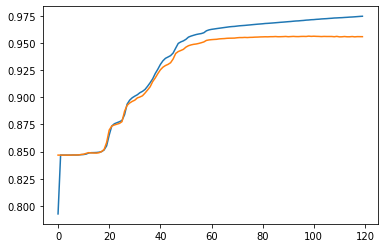

In [16]:
plot_hist(history8)

In [17]:
pred8 = model.predict(X_word_te)

In [18]:
pred_tags = get_tags(pred8)

In [23]:
total_tags = 0
count_padding = 0
count_other = 0

for sent in new_y_te:
    for tag in sent:
        total_tags+=1
        if(tag == 0):
            count_padding +=1
        if(tag == tag2idx["O"]):
            count_other+=1
            
hits = 0
count_pad = 0
count_o = 0

for real_tag,pred_tag in zip(y_te,pred_tags):
    for y,yhat in zip(real_tag,pred_tag):
           if(y == yhat and yhat != 0 and y != tag2idx["O"]):
               hits +=1
           if(yhat == tag2idx["PAD"] == y):
               count_pad +=1
           if(yhat == tag2idx["O"] == y):
               count_o +=1

In [24]:
print_scores(hits,count_pad,count_o)

Total tags : 359700
# of 'P' : 254383
# of 'O' : 89177
Total tags left without O,P : 16140
# of hits without 'PAD' and 'O' : 12534
# of predicted - 'O' : 88150
# of predicted - 'PAD' : 0
Accuracy rate :  0.7765799256505577


### Model 5 : LSTM-CRF word based

In [ ]:
word_input = Input(shape = (X_word_tr.shape[1],))
emb_word = Embedding(input_dim = n_words + 1,output_dim=16,mask_zero = True,input_length = max_len)(word_input)

model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(emb_word)  # variational biLSTM

model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1,activation = "sigmoid")  # CRF layer
out = crf(model)  # output

model = Model(word_input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

C:\Anaconda\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Anaconda\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


In [ ]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 75)                0         
_________________________________________________________________
embedding_28 (Embedding)     (None, 75, 16)            562864    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 75, 100)           26800     
_________________________________________________________________
time_distributed_28 (TimeDis (None, 75, 50)            5050      
_________________________________________________________________
crf_16 (CRF)                 (None, 75, 19)            1368      
Total params: 596,082
Trainable params: 596,082
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history10 = model.fit(X_word_tr,y_tr2,validation_data = (X_word_te,y_te2),epochs = 10,batch_size=round(X_word_tr.shape[0]/3)+2)

Train on 43162 samples, validate on 4796 samples
Epoch 1/10
43162/43162 [==============================] - 240s 6ms/step - loss: 11.0862 - crf_viterbi_accuracy: 0.8435 - val_loss: 10.9841 - val_crf_viterbi_accuracy: 0.8444
Epoch 2/10
43162/43162 [==============================] - 247s 6ms/step - loss: 11.0765 - crf_viterbi_accuracy: 0.8447 - val_loss: 10.9754 - val_crf_viterbi_accuracy: 0.8451
Epoch 3/10
43162/43162 [==============================] - 238s 6ms/step - loss: 11.0681 - crf_viterbi_accuracy: 0.8455 - val_loss: 10.9677 - val_crf_viterbi_accuracy: 0.8456
Epoch 4/10
43162/43162 [==============================] - 244s 6ms/step - loss: 11.0605 - crf_viterbi_accuracy: 0.8460 - val_loss: 10.9606 - val_crf_viterbi_accuracy: 0.8459
Epoch 5/10
43162/43162 [==============================] - 238s 6ms/step - loss: 11.0536 - crf_viterbi_accuracy: 0.8463 - val_loss: 10.9540 - val_crf_viterbi_accuracy: 0.8462
Epoch 6/10
43162/43162 [==============================] - 241s 6ms/step - loss: 1

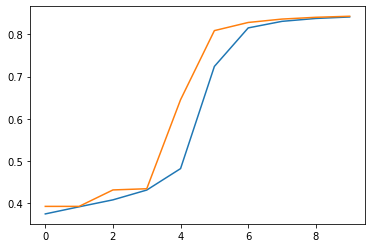

In [ ]:
plt.plot(history10.history['crf_viterbi_accuracy']) # this is the first run of 10 epochs. got 0 accuracy.
plt.plot(history10.history['val_crf_viterbi_accuracy'])

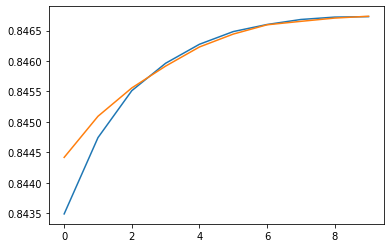

In [ ]:
plt.plot(history10.history['crf_viterbi_accuracy']) # after 10 more epochs
plt.plot(history10.history['val_crf_viterbi_accuracy'])

In [ ]:
pred10 = model.predict(X_word_te)

In [ ]:
pred_tags = get_tags(pred10)

In [ ]:
hits,count_pad,count_o = get_hits(new_y_te,pred_tags)

In [ ]:
print_scores(hits,count_pad,count_o)

Total tags : 359700
# of 'P' : 254383
# of 'O' : 89177
Total tags left without O,P : 16140
# of hits without 'PAD' and 'O' : 0
# of predicted - 'O' : 105315
# of predicted - 'PAD' : 254383
Accuracy rate :  0.0


# Difficulties and future work

While working on this project, i have faced some difficulties.<br>
My main problam was my small dataset, in order to train a deep neural network model well, planty of data is required, NER is relatively old, while Hebrew tagged data is very hard to manage thesedays.<br>
Building a strong model, requires a good parameters and initializers choosing, architecture etc. so in order to find the best "fit", alot of practice is needed.<br>
Another tricky issue is to keep up with the layers shapes, outputs and vector transforming, it is importent to understand the model's data shape.<br><br>
A note about models 5 and 6 - <br>
Unfortunatly, models 5 and 6 requiers heavie computing, COLAB keras_contrib version doesnt match the CRF version, so i had to run the model on my on CPU, which is alot weaker, hence, # of epochs is very small and the accuracy rate of this models is very low,specially on the english dataset (because its alot bigger). I'm SURE running more epochs will get better results.<br><br>
To implement:<br>
Pointer Networks - https://arxiv.org/pdf/1812.09449.pdf<br>
ELMo Embedding - https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/ <br>
Deep transfer learning with multitask bi-directional LSTM RNN - https://ccsb.pvamu.edu/papers/dong-multitask-bidirectional-lstm-rnn-chinese-emr/ <br>
Better char encoding approach.

# Summary

<center>Hebrew models:</center>
<table>
  <tr>
    <th># Model</th>
    <th># Parameters</th>
    <th>Accuracy</th>
    <th>Description</th> 
  </tr>
  <tr>
    <td>1</td>
    <td>3,099</td>
    <td>0</td>
    <td>Simple NN</td>
  </tr>
  <tr>
    <td>2</td>
    <td>301,019</td>
    <td>0.5786</td>
    <td>Simple LSTM</td>
  </tr>
  <tr>
    <td>3</td>
    <td>338,959</td>
    <td>0.4806</td> 
    <td>Complex LSTM network</td>
      
  </tr>
  <tr>
    <td>4</td>
    <td>327,724</td>
    <td>0.4152</td> 
    <td>GRU Network</td>
  </tr>
  <tr>
    <td>5</td>
    <td>333,266</td>
    <td>0.5847</td> 
    <td>LSTM - CRF word based</td>
  </tr>
  <tr>
    <td>6</td>
    <td>342,718</td>
    <td>0.0157</td>
    <td>LSTM - CRF word and char</td>
  </tr>
</table>
<br>
<center>English models:</center>

<table>
  <tr>
    <th># Model</th>
    <th># Parameters</th>
    <th>Accuracy</th>
  </tr>
  <tr>
    <td>2</td>
    <td>563,835</td>
    <td>0.7765</td>
  </tr>
  <tr>
    <td>5</td>
    <td>605,486</td>
    <td>0</td> 
  </tr>
  </table>

# Final Conclusions

Named entity recognition is a hard task in the field of NLP, there are many langauges that needs to be handled, each langauge has its own pragmatics, semantics and syntax, which makes the solution even harder.<br>
many of insights have learned thourghout this project.<br>
First, in order to get good results and a strong model, a LARGE dataset is required, as we have seen while comparing the small hebrew dataset to the english dataset.<br>
Second, sometimes, when working with a small dataset, going deeper and heavier with the model architecture wont always help, in fact, sometimes it can get worse.<br>
Theird, it is importent to understand your dataset, and engineer it right, I'm sure that preforming a good feature engineering and corpus constructing will help the process become better (e.g. word embedding).<br>
Fourth, Because time and GPU limitations, parameter choosing is a long and confusing process, while choosing them right, can help tune up the whole model.<br>
Fifth, There are many "addons" to add a model (e.g. cuDNN) in order the accelerate the model and get better results, it is imported to be familiar with the ones in your niche.<br>
Sixth, IDE choosing is very importent, some models requiers their own environment setup with specific packages versions, i found myslef switching between COLAB and jupyter in order to custom environment versions, which made my work twice hard.